In [110]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

image.shape: torch.Size([1, 28, 28])
Label: 5


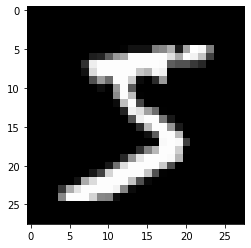

In [111]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [112]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [113]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [114]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        # hidden layer1
        self.linear1 = nn.Linear(in_size, hidden_size1)
        # hidden layer2
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # output layer
        self.linear3 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [115]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [116]:
input_size = 784
hidden_size1 = 64 # you can change this
hidden_size2 = 32
num_classes = 10
model = MnistModel(input_size, hidden_size1, hidden_size2, out_size=num_classes)
for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [117]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.314816474914551
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1515, -0.0164,  0.0637, -0.0940,  0.0375,  0.1448, -0.1739, -0.1321,
         -0.1302, -0.1905],
        [ 0.1756,  0.0275,  0.0472, -0.0767,  0.1009,  0.1143, -0.1527, -0.0960,
         -0.1171, -0.1829]])


In [118]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [119]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3089051246643066, 'val_acc': 0.09638671576976776}]

In [120]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2051, val_acc: 0.9362
Epoch [1], val_loss: 0.2135, val_acc: 0.9308
Epoch [2], val_loss: 0.1215, val_acc: 0.9615
Epoch [3], val_loss: 0.1143, val_acc: 0.9655
Epoch [4], val_loss: 0.1665, val_acc: 0.9500


In [121]:
history += fit(5, 0.1, model, train_loader, val_loader) # small learning rate

Epoch [0], val_loss: 0.0854, val_acc: 0.9737
Epoch [1], val_loss: 0.0851, val_acc: 0.9739
Epoch [2], val_loss: 0.0863, val_acc: 0.9739
Epoch [3], val_loss: 0.0847, val_acc: 0.9738
Epoch [4], val_loss: 0.0863, val_acc: 0.9742


In [122]:
history += fit(5, 0.01, model, train_loader, val_loader) # small learning rate

Epoch [0], val_loss: 0.0834, val_acc: 0.9749
Epoch [1], val_loss: 0.0833, val_acc: 0.9754
Epoch [2], val_loss: 0.0837, val_acc: 0.9748
Epoch [3], val_loss: 0.0836, val_acc: 0.9755
Epoch [4], val_loss: 0.0838, val_acc: 0.9751


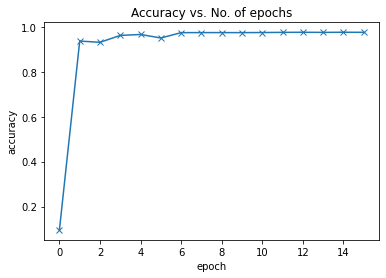

In [123]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [124]:
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

In [125]:
img, label = test_dataset[0]
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()
predict_image(img, model)

7

In [126]:
for i in range(20):
    img, label = test_dataset[i]
    pred = predict_image(img, model)
    if pred == label:
        print("Label: ", label, "Predict: ", pred, "Yes")
    else:
        print("Label: ", label, "Predict: ", pred, "No")


Label:  7 Predict:  7 Yes
Label:  2 Predict:  2 Yes
Label:  1 Predict:  1 Yes
Label:  0 Predict:  0 Yes
Label:  4 Predict:  4 Yes
Label:  1 Predict:  1 Yes
Label:  4 Predict:  4 Yes
Label:  9 Predict:  9 Yes
Label:  5 Predict:  5 Yes
Label:  9 Predict:  9 Yes
Label:  0 Predict:  0 Yes
Label:  6 Predict:  6 Yes
Label:  9 Predict:  9 Yes
Label:  0 Predict:  0 Yes
Label:  1 Predict:  1 Yes
Label:  5 Predict:  5 Yes
Label:  9 Predict:  9 Yes
Label:  7 Predict:  7 Yes
Label:  3 Predict:  3 Yes
Label:  4 Predict:  4 Yes


In [127]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.07747671753168106, 'val_acc': 0.975878894329071}

In [128]:
# save and reload trained model
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [129]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0215, -0.0322, -0.0041,  ..., -0.0314, -0.0230,  0.0191],
                      [-0.0227, -0.0134,  0.0100,  ..., -0.0038,  0.0185, -0.0087],
                      [-0.0335,  0.0075,  0.0121,  ...,  0.0191,  0.0255, -0.0066],
                      ...,
                      [-0.0256,  0.0026,  0.0127,  ...,  0.0038, -0.0354, -0.0253],
                      [-0.0311, -0.0211,  0.0154,  ..., -0.0134, -0.0356,  0.0279],
                      [-0.0184,  0.0171,  0.0148,  ...,  0.0027, -0.0344, -0.0023]])),
             ('linear1.bias',
              tensor([ 0.0552, -0.0624,  0.1588,  0.0630, -0.0135, -0.1381,  0.0226, -0.1442,
                      -0.2062,  0.0027, -0.2543, -0.0334, -0.2168, -0.0311,  0.1815,  0.0329,
                       0.2390, -0.0144,  0.0449,  0.0307,  0.0366, -0.0079,  0.0092,  0.2058,
                       0.4038,  0.2215, -0.0295,  0.0552,  0.0331, -0.1183,  0.0534,  0.3658,
                       0.201

In [130]:
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
num_classes = 10
model2 = model = MnistModel(input_size, hidden_size1, hidden_size2, out_size=num_classes)
model2.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0044,  0.0217,  0.0317,  ...,  0.0072,  0.0097, -0.0073],
                      [-0.0052, -0.0343,  0.0246,  ..., -0.0137,  0.0184, -0.0073],
                      [-0.0188, -0.0109,  0.0276,  ...,  0.0200,  0.0030, -0.0246],
                      ...,
                      [-0.0067, -0.0109, -0.0335,  ..., -0.0145, -0.0279, -0.0021],
                      [ 0.0277,  0.0109,  0.0265,  ..., -0.0095, -0.0229,  0.0178],
                      [-0.0115,  0.0310, -0.0208,  ..., -0.0125,  0.0154, -0.0272]])),
             ('linear1.bias',
              tensor([-0.0173, -0.0074, -0.0069, -0.0184, -0.0227, -0.0263,  0.0020, -0.0291,
                       0.0151, -0.0125, -0.0288,  0.0165,  0.0323,  0.0263,  0.0126,  0.0230,
                       0.0099,  0.0007, -0.0045,  0.0347, -0.0136,  0.0208, -0.0099, -0.0227,
                      -0.0186, -0.0130,  0.0064,  0.0105, -0.0159, -0.0104,  0.0232, -0.0146,
                       0.016

In [131]:
result = evaluate(model2, test_loader)
result

{'val_loss': 2.310168743133545, 'val_acc': 0.06074218824505806}

In [132]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0215, -0.0322, -0.0041,  ..., -0.0314, -0.0230,  0.0191],
                      [-0.0227, -0.0134,  0.0100,  ..., -0.0038,  0.0185, -0.0087],
                      [-0.0335,  0.0075,  0.0121,  ...,  0.0191,  0.0255, -0.0066],
                      ...,
                      [-0.0256,  0.0026,  0.0127,  ...,  0.0038, -0.0354, -0.0253],
                      [-0.0311, -0.0211,  0.0154,  ..., -0.0134, -0.0356,  0.0279],
                      [-0.0184,  0.0171,  0.0148,  ...,  0.0027, -0.0344, -0.0023]])),
             ('linear1.bias',
              tensor([ 0.0552, -0.0624,  0.1588,  0.0630, -0.0135, -0.1381,  0.0226, -0.1442,
                      -0.2062,  0.0027, -0.2543, -0.0334, -0.2168, -0.0311,  0.1815,  0.0329,
                       0.2390, -0.0144,  0.0449,  0.0307,  0.0366, -0.0079,  0.0092,  0.2058,
                       0.4038,  0.2215, -0.0295,  0.0552,  0.0331, -0.1183,  0.0534,  0.3658,
                       0.201

In [133]:
result = evaluate(model2, test_loader)
result

{'val_loss': 0.07747671753168106, 'val_acc': 0.975878894329071}